# CS216 Final Project: Group 26
#### Jack Lichtenstein, Shannon Houser, Libba Lawrence, and Linda Tang

## Part 1: Introduction and Research Questions

Spotify is one of the world's largest music streaming service providers with over 365 million monthly active users. 
The Spotify database includes a variety of information on the characteristics and metrics of song tracks. Each song on Spotify is associated with a popularity index ranging from 0 to 100 reflecting how popular a song is relative to other songs. In this project, we plan to apply the analysis techniques that we learned in class to the Spotify music database. The **research question** is how can we predict the popularity of a song using characteristics such as danceability, energy, loudness and artist (descrbed below in the data sources section). We plan to explore different machine learning algorithms such as linear regression, decision trees and support vector regression and compare their relative performance on prediction. The scope of the project is feasible since the dataset we will use is readily avaiable online through Kaggle, the dataset contains a variety of songs and variables for analysis and it's in a relatively clean format. The algorithm from our project could  be helpful for the artist community to predict the popularity of new release songs ahead of time and could inform future researches on understanding what factors influence popularity on Spotify. 

## Part 2: Data Sources 

The data used for this project comes from an episode of the [Sliced](https://www.notion.so/SLICED-Show-c7bd26356e3a42279e2dfbafb0480073) data science challenge held in summer 2021. The data is accessible publicly on [Kaggle](https://www.kaggle.com/c/sliced-s01e08-KJSEks/data), and was initially extracted from the Spotify Web API. The competition provides three datasets, each of which we will make use of to answer our research questions:

- train.csv - the training set
- test.csv - the test set
- artists.csv - data about artists in the dataset

The train and test datasets are formatted the same way. We read in `train.csv` and `artists.csv` below. Additionally, we provide an in-depth data description as well. NOTE: `test.csv` does not have actual values for `popularity`, we decided to split the `train.csv` set into our own test and train sets (75-25 split), disregarding the provided test set entirely.

### Data Dictionary

Response variable:
- The Spotify Popularity Index is a 0-to-100 score that ranks how popular an artist is relative to other artists on Spotify. The Index can be used to monitor and influence the progress of new releases, its calculation can be influenced by recent stream count, save rate, the number of playlists, skip rate, and share rate, etc. 

Predictor variables - the audio features as defined by the Spotify API:
- Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- Acousticness: A measure from 0.0 to 1.0 of whether the track is acoustic.
- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
- Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [1]:
# import some libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

# setup the Seaborn style 
sns.set_theme()
sns.set_context('talk')

In [2]:
# change to one directory back (only run this once)
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [3]:
# read in dataset
dataset = pd.read_csv("data/train.csv")
# remove brackets from artist id and split by comma
dataset['id_artists'] = dataset['id_artists'].str.strip('[]').str.split(', ')
# separate each artist into it's own row
dataset_explode = dataset.explode('id_artists')
dataset_explode['id_artists'] = dataset_explode['id_artists'].str.strip("''")

# read in spotify artist data
spotify_artists = pd.read_csv("data/artists.csv")
# rename columns
spotify_artists = spotify_artists.rename({'id':'id_artists', 'name':'artist_name', 
                                          'popularity':'artist_popularity'}, axis = 1)

# join in artist information from `spotify_artists` to create full dataset
artist_songs = pd.merge(dataset_explode[['id', 'id_artists']], 
                        spotify_artists, 
                        left_on = 'id_artists', 
                        right_on = 'id_artists', how = 'left')

# find mean followers, mean artist popularity, number of artists for each song
artist_songs_summarized = artist_songs.groupby(['id']) \
.agg({'followers': np.mean, 
      'artist_popularity': np.mean, 
      'id_artists': 'count'})\
.rename(columns={'id_artists':'n_artists'})\
.reset_index()

# join in artist information from `artist_songs_summarized` to create full dataset
dataset = pd.merge(dataset, artist_songs_summarized, left_on = 'id', right_on = 'id', how = 'left')
dataset.head()

,id,name,popularity,duration_ms,artists,id_artists,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,release_year,release_month,release_day,followers,artist_popularity,n_artists
0,269,blun7 a swishland,63,167760.0,['tha Supreme'],['19i93sA0D7yS9dYoVNBqAA'],0.692,0.792,7,-5.984,...,0.000000,0.2550,0.566,129.883,2019,11.0,15.0,1337237.0,73.0,1
1,27504,Que Me Perdone Tu Señora,42,150640.0,['Manoella Torres'],['4JRKcLbpjobmoOVoOXPd6y'],0.608,0.447,6,-12.151,...,0.000035,0.1690,0.673,90.777,2007,3.0,21.0,86333.0,49.0,1
2,16082,愛唄~since 2007~,42,242373.0,['whiteeeen'],['6v3VFX2qIWthj4Lr5QIxts'],0.572,0.782,8,-5.275,...,0.000000,0.3740,0.450,170.050,2016,3.0,9.0,18320.0,36.0,1
3,14585,Let me be your uncle tonight,12,202989.0,['Tvíhöfði'],['6rmrk3Jk0Ecf8fjioCCZmV'],0.855,0.470,7,-9.252,...,0.000002,0.2640,0.864,102.008,2001,1.0,1.0,1882.0,19.0,1
4,14740,Never Going Back Again - 2004 Remaster,40,134400.0,['Fleetwood Mac'],['08GQAI4eElDnROBrJRGE0X'],0.654,0.336,6,-12.825,...,0.385000,0.0786,0.947,176.083,1977,2.0,4.0,6343791.0,85.0,1


In [43]:
from sklearn.model_selection import train_test_split

# target is popularity of the song
target = dataset['popularity']

# split to train and testing datasets
train, test, train_target, test_target = train_test_split(dataset, 
                                                          target, 
                                                          test_size=0.25, # 75, 25 split
                                                          random_state=216)

## Exploratory Data Analysis

### Visualization

In [5]:
# remove brackets from genres and split by comma
spotify_artists['genres'] = spotify_artists['genres'].str.strip('[]').str.split(', ')
# separate each genre into it's own row
spotify_artists = spotify_artists.explode('genres')

In [6]:
spotify_artists['genres'] = spotify_artists['genres'].str.strip("'")
# get rid of genres that are blank
spotify_artists = spotify_artists[spotify_artists['genres'] != '']

In [7]:
# coun the most frequent genres
genre_counts = spotify_artists['genres'].value_counts().reset_index().rename(columns={'index': 'genre', 'genres': 'count'})

[Text(0.5, 0, 'Count'),
 Text(0, 0.5, ' '),
 Text(0.5, 1.0, 'Ten Most Common Artist Genres')]

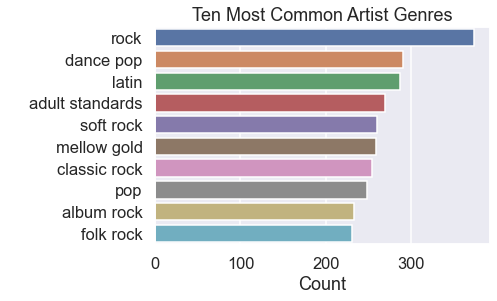

In [8]:
# plot most common genres that artists use
sns.barplot(x = 'count', y = 'genre', data = genre_counts.head(10)).set(xlabel = "Count", ylabel = " ", title = "Ten Most Common Artist Genres")

[Text(0.5, 0, 'Song Popularity'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, "Distribution of Songs' Popularity")]

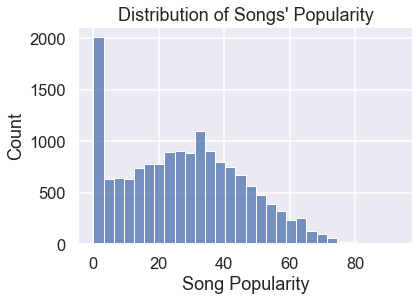

In [9]:
sns.histplot(x = 'popularity', data = train, bins = 30).set(xlabel = "Song Popularity", ylabel = "Count", title = "Distribution of Songs' Popularity")

In [10]:
train_names = train.rename({'followers':'CharacteristicArtistFollowers', 
                            'n_artists':'CharacteristicNArtists', 
                            'artist_popularity':'CharacteristicArtistPopularity', 
                            'danceability':'CharacteristicDanceability', 
                            'energy':'CharacteristicEnergy', 'key':'CharacteristicKey', 
                            'loudness':'CharacteristicLoudness', 
                            'speechiness':'CharacteristicSpeechiness', 
                            'acousticness':'CharacteristicAcousticness', 
                            'instrumentalness': 'CharacteristicInstrumentalness', 
                            'liveness':'CharacteristicLiveness', 
                            'valence':'CharacteristicValence', 
                            'tempo':'CharacteristicTempo', 
                            'release_year':'CharacteristicRelease year'}, axis = 1)
#pd.wide_to_long(train_names, "Characteristic", i = 'id', j = "Value")
A = set(train.columns)
B = set(train_names.columns)
A.intersection(B)
train_long = pd.melt(train, id_vars = A.intersection(B))

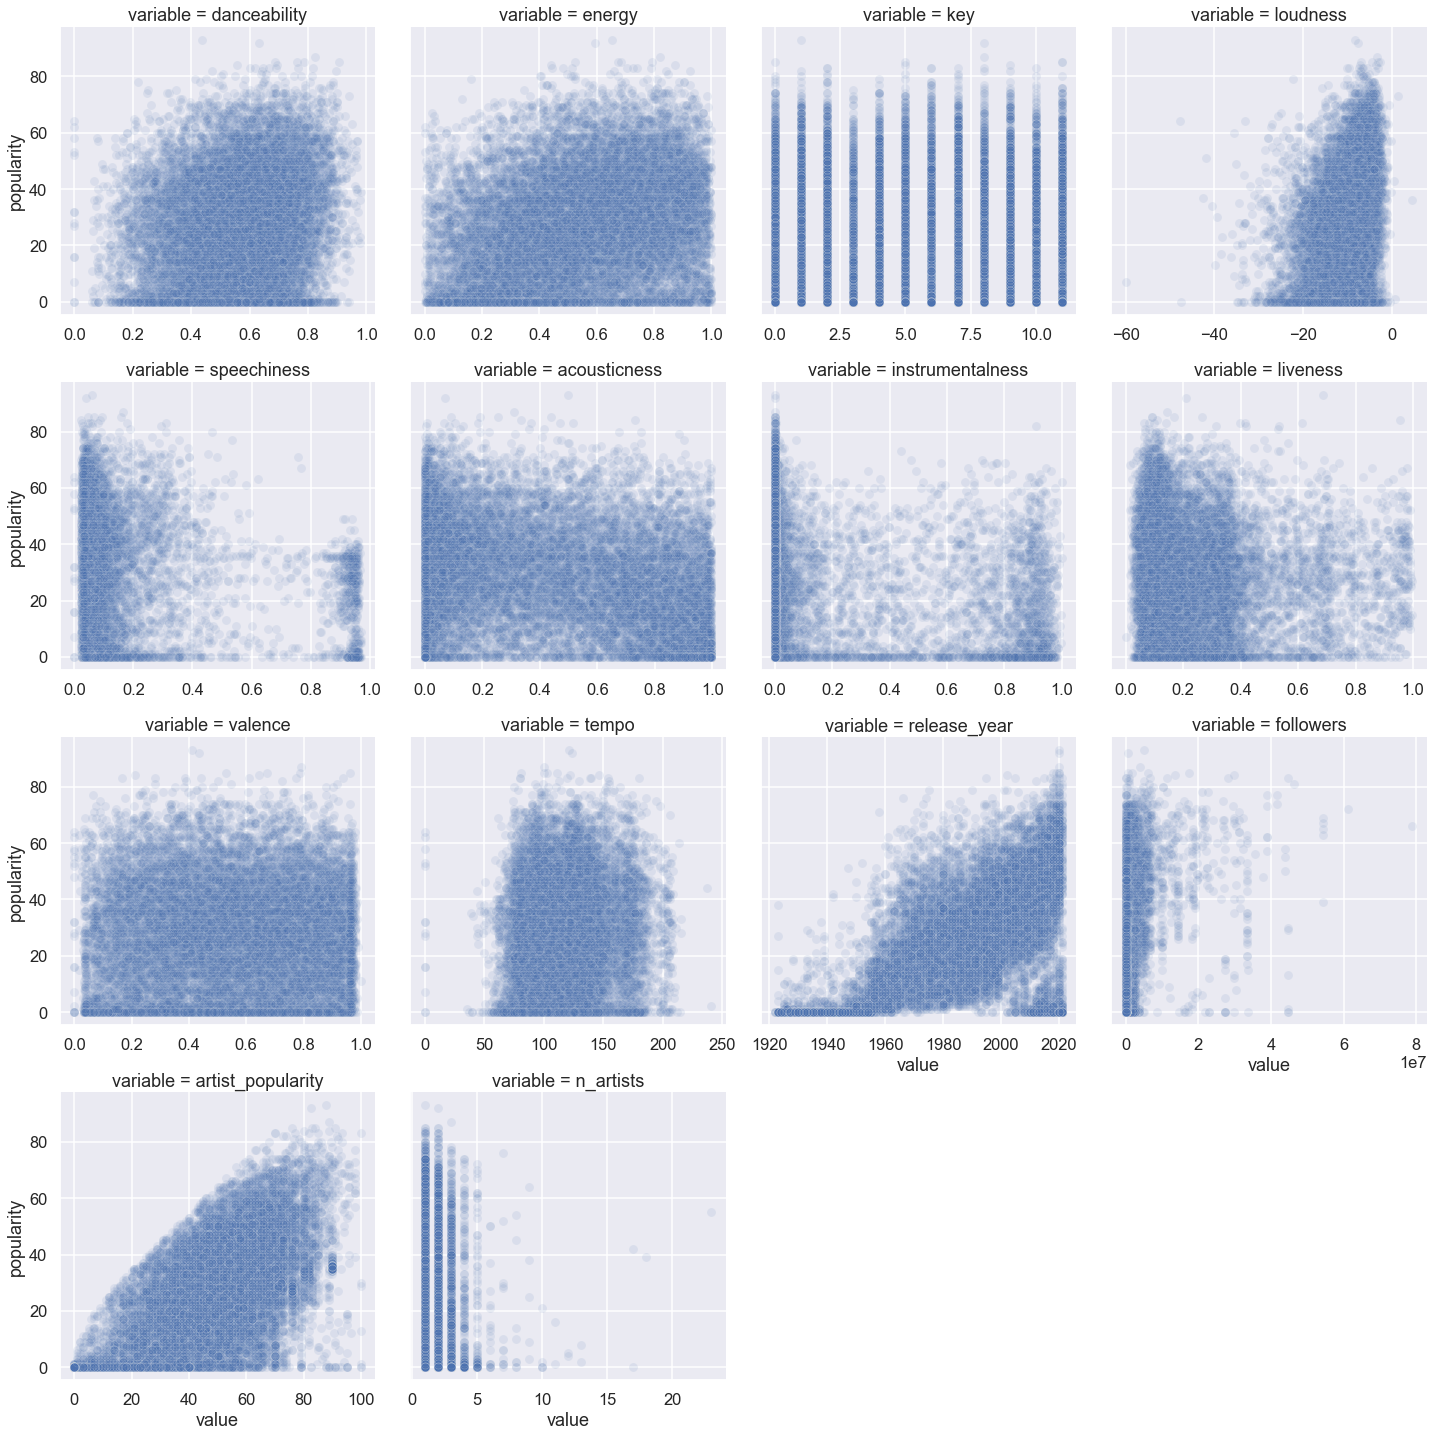

In [11]:
sns.relplot(y = 'popularity', x = 'value', col = 'variable', 
            col_wrap = 4, alpha = .1, data = train_long, facet_kws={'sharey': True, 'sharex': False})
#sns.FacetGrid(data = train_long, col = 'variable')

### Feature Engineering

- replace missing values with mean

In [12]:
# import sci-kit learn
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import random
# data = train[['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
# 'instrumentalness', 'liveness', 'valence', 'tempo', 'release_year']]

# numeric features
feats = ['danceability', 'energy', 'speechiness', 
         'acousticness', 'instrumentalness', 
         'liveness', 'valence', 'release_year',
         'artist_popularity', 'followers', 'n_artists']

# target variable
target = 'popularity'

# set a seed and make 10 folds for CV
random.seed(123)
kf = KFold(10, shuffle=True)

# model_data is just features and target
model_data = train.loc[:, feats+[target]] #.dropna()
test_data = test.loc[:, feats+[target]]

In [13]:
# replace missing data with mean (artist_popularity, followers) because they are not found in `spotify_artists`
na_cols_train = model_data.columns[model_data.isna().any()].tolist()
na_cols_test = test_data.columns[test_data.isna().any()].tolist()

# col = 'followers'
# model_data[f"{col}_na"] = np.where(model_data[col].isna(), True, False)
# model_data[col] = model_data[col].fillna(model_data[col].mean())

# model_data[model_data['release_year_na'] == True]
# 
for col in na_cols_train:
    model_data[f"{col}_na"] = np.where(model_data[col].isna(), True, False)
    model_data[col] = model_data[col].fillna(model_data[col].mean())
    
for col in na_cols_test:
    test_data[f"{col}_na"] = np.where(test_data[col].isna(), True, False)
    test_data[col] = test_data[col].fillna(test_data[col].mean())

# model_data[model_data['artist_popularity_na'] == True]

# model_data[model_data[['artist_popularity', 'followers']].isna() == True]

# spotify_artists[spotify_artists['id_artists'] == '3lYCVZw8xWYZtoYWQUUDFP']

# Part 3: Preliminary Results and Methods

We try a variety of modeling approaches in an effort to best predict a song's popularity. Specifically, we try ordinary least squares, LASSO regularized regression, k-nearest-neighbors, random forests, and support vector machines. We perform 10-fold cross-validation on each model specification, selecting hyperparameters by root mean squared error.

In [14]:
# function to perform manual crossfold validation given a model specification
def manual_cv(model_data, kf, model):
    random.seed(234)
    df_preds = pd.DataFrame()

    # crossfold validation
    for train_idx, test_idx in kf.split(model_data):
        # analysis set
        train_data = model_data.iloc[train_idx]
        # asessment set
        test_data = model_data.iloc[test_idx]
    
        # model specification
        model.fit(X = train_data.loc[:, feats], y = train_data[target])
        # predict
        test_data['pred'] = pd.DataFrame(model.predict(test_data.loc[:, feats]), index=test_data.index)
        df_preds = df_preds.append(test_data)
    
    return df_preds

# function to calculate rmse and r2 for different parameters of a model specification
def calculate_metrics(preds, variable):
    metrics = pd.DataFrame()

    # find rmse and r2 for each hyperparameter
    for var in preds[variable].unique().tolist():
        # filter for a hyperparameter
        filtered = preds[preds[variable] == var]
    
        # calculate metrics
        rmse = np.sqrt(mean_squared_error(filtered["popularity"].values, filtered["pred"].values))
        r2 = r2_score(filtered["popularity"].values, filtered["pred"].values)
    
        # initialize data
        mets = {variable:[var],
                'rmse':[rmse],
                'r2':[r2]}
  
        # create DataFrame
        mets = pd.DataFrame(mets)
        metrics = metrics.append(mets)
    
    # delete big data frame of CV predictions
    del [[preds]]
    return metrics

# function to plot CV metrics
def plot_metrics(metrics, var):
    # pivot long
    metrics_long = metrics.melt(id_vars=[var], value_vars=['rmse', 'r2'])

    # plot metrics by variable
    g = sns.FacetGrid(metrics_long, col = 'variable', sharex=True, sharey=False, 
                  col_wrap=4, height=3, aspect=1.618)
    return g.map(sns.lineplot, var, 'value')

# function to predict on the test set
def predict_on_test(model):
    # predict on test
    test["pred"] = model.predict(test_data.loc[:, feats])

    # calculate metrics
    rmse = np.sqrt(mean_squared_error(test["popularity"].values, test["pred"].values))
    r2 = r2_score(test["popularity"].values, test["pred"].values)
    
    return rmse, r2 #, test

# helper function to create dataframe of test metrics
def create_metric_df(model_type, rmse, r2):
    # initialize data
    mets = {'model':[model_type],
            'rmse':[rmse],
            'r2':[r2]}
  
    # create DataFrame
    return pd.DataFrame(mets)

## Ordinary Least Squares Regression

Linear regression is parametric and highly interpretable. Although currently the model is not achieving great predictive performance, examining the coefficients can help us understand the relationship between each metrics and popularity. 

In [15]:
from sklearn.linear_model import LinearRegression

# LinearRegression() cross validation
lin_preds = manual_cv(model_data = model_data, kf = kf, model = LinearRegression())

rmse = np.sqrt(mean_squared_error(lin_preds[target], lin_preds['pred']))
r2 = r2_score(lin_preds[target], lin_preds['pred'])

print("CV OLS RMSE:", rmse, "CV OLS r^2:", r2)

CV OLS RMSE: 12.832932107772514 CV OLS r^2: 0.5156061019259195


In [16]:
lin_model = LinearRegression()
lin_model.fit(X = model_data.loc[:, feats], y = train_target)

# predict on test set
rmse, r2 = predict_on_test(model = lin_model)
ols_test_metrics = create_metric_df(model_type = 'OLS', rmse = rmse, r2 = r2)
print("Testing OLS RMSE:", rmse, "Testing OLS r^2:", r2)

Testing OLS RMSE: 12.662707688732924 Testing OLS r^2: 0.5358326299237293


## LASSO (with cross validation)

LASSO performs variable selection and this regularization could improve the predictive performance of the model.

In [17]:
from sklearn.linear_model import Lasso

lasso_preds = pd.DataFrame()

# perform crossfold validation of LASSO penalty from 10^-6 to 10^0.5
for pen in np.arange(-5.0, 1.0, 0.5).tolist():
    preds = manual_cv(model_data = model_data, kf = kf, model = Lasso(alpha = 10**pen))
    preds['penalty'] = pen
    
    lasso_preds = lasso_preds.append(preds)

In [18]:
lasso_metrics = calculate_metrics(preds = lasso_preds, variable = 'penalty')

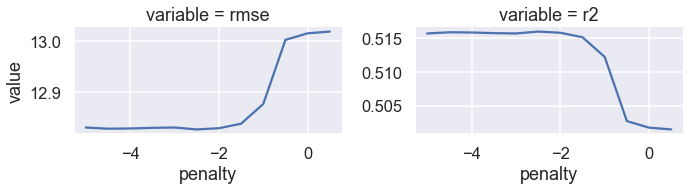

In [19]:
plot_metrics(metrics = lasso_metrics, var = 'penalty')

In [20]:
# get best by rmse
penalty = lasso_metrics.nsmallest(1, 'rmse')['penalty'].astype(float)[0]
print("Best CV lambda penalty is", 10**penalty)

# fit to training with best lambda penalty
lasso_model = Lasso(alpha = 10**penalty)
lasso_model.fit(X = model_data.loc[:, feats], y = train_target)

# predict on test set
rmse, r2 = predict_on_test(model = lasso_model)
lasso_test_metrics = create_metric_df(model_type = 'LASSO', rmse = rmse, r2 = r2)
print("Testing LASSO RMSE:", rmse, "Testing LASSO r^2:", r2)

Best CV lambda penalty is 0.0031622776601683794
Testing LASSO RMSE: 12.661657389316517 Testing LASSO r^2: 0.5359096268049031


## KNN (with CV)

In [37]:
from sklearn.neighbors import KNeighborsRegressor

knn_preds = pd.DataFrame()

# perform crossfold validation of k-nearest neighbors
for neighbor in range(3, 15+1):
    preds = manual_cv(model_data = model_data, kf = kf, model = KNeighborsRegressor(n_neighbors = neighbor))
    preds['neighbors'] = neighbor
    
    knn_preds = knn_preds.append(preds)

In [38]:
knn_metrics = calculate_metrics(preds = knn_preds, variable = 'neighbors')

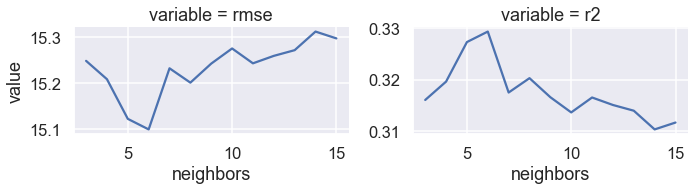

In [39]:
plot_metrics(metrics = knn_metrics, var = 'neighbors')

In [41]:
# get best KNN by mse
neighbors = knn_metrics.nsmallest(1, 'rmse')['neighbors'].astype(int)[0]
print("Best CV KNN is", neighbors)

# fit to training with best K
knn_model = KNeighborsRegressor(n_neighbors = neighbors)
knn_model.fit(X = model_data.loc[:, feats], y = train_target)

# predict on test set
rmse, r2 = predict_on_test(model = knn_model)
knn_test_metrics = create_metric_df(model_type = 'KNN', rmse = rmse, r2 = r2)
print("Testing KNN RMSE:", rmse, "Testing KNN r^2:", r2)

Best CV KNN is 6
Testing KNN RMSE: 15.50674934124735 Testing KNN r^2: 0.3039138739763835


## Random Forest (with CV)

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_preds = pd.DataFrame()

# perform crossfold validation of k-nearest neighbors from 10-20 neighbors
for depth in range(5, 7+1):
    preds = manual_cv(model_data = model_data, kf = kf, model = RandomForestRegressor(n_estimators = 500,
                                                                                      max_depth = depth))
    preds['max_depth'] = depth
    
    rf_preds = rf_preds.append(preds)

In [26]:
rf_metrics = calculate_metrics(preds = rf_preds, variable = 'max_depth')

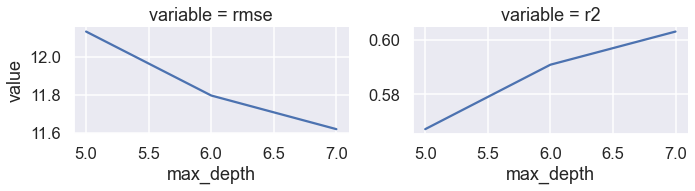

In [27]:
plot_metrics(metrics = rf_metrics, var = 'max_depth')

In [28]:
# get best max_depth by mse
max_depth = rf_metrics.nsmallest(1, 'rmse')['max_depth'].astype(int)[0]
print("Best CV max_depth is", max_depth)

# fit to training with best max_depth
rf_model = RandomForestRegressor(n_estimators = 500,
                                 max_depth = max_depth)
rf_model.fit(X = model_data.loc[:, feats], y = train_target)

# predict on test set
rmse, r2 = predict_on_test(model = rf_model)
rf_test_metrics = create_metric_df(model_type = 'Random Forest', rmse = rmse, r2 = r2)
print("Testing random forest RMSE:", rmse, "Testing random forest r^2:", r2)

Best CV max_depth is 7
Testing random forest RMSE: 11.49549373897104 Testing random forest r^2: 0.6174601329143135


## Support Vector Regression

In [29]:
from sklearn.svm import SVR

svr_preds = pd.DataFrame()

# perform crossfold validation
for cost in [10, 100, 1000]:
    preds = manual_cv(model_data = model_data, kf = kf, model = SVR(C = cost))
    preds['C'] = cost
    
    svr_preds = svr_preds.append(preds)

In [30]:
svr_metrics = calculate_metrics(preds = svr_preds, variable = 'C')

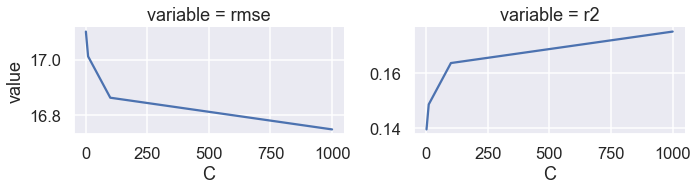

In [31]:
plot_metrics(metrics = svr_metrics, var = 'C')

In [32]:
# get best C by mse
c = svr_metrics.nsmallest(1, 'rmse')['C'].astype(int)[0]
print("Best CV C is", c)

# fit to training with best max_depth
svr_model = SVR(C = c)
svr_model.fit(X = model_data.loc[:, feats], y = train_target)

# predict on test set
rmse, r2 = predict_on_test(model = svr_model)
svr_test_metrics = create_metric_df(model_type = 'SVR', rmse = rmse, r2 = r2)
print("Testing support vector machine RMSE:", rmse, "Testing support vector machine r^2:", r2)

Best CV C is 1000
Testing support vector machine RMSE: 16.681281218209637 Testing support vector machine r^2: 0.19447272163610674


/Users/JackLich/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


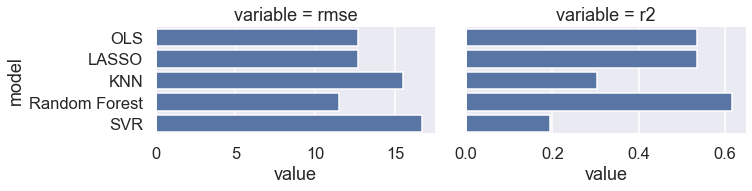

In [42]:
# all test metrics together
all_test_metrics = pd.concat([ols_test_metrics, lasso_test_metrics,
                              knn_test_metrics, rf_test_metrics, svr_test_metrics])

# pivot long
all_test_metrics_long = all_test_metrics.melt(id_vars=['model'], value_vars=['rmse', 'r2'])

# plot metrics
g = sns.FacetGrid(all_test_metrics_long, col = "variable", sharex=False, sharey=True, 
                  col_wrap=4, height=3, aspect=1.618)
g.map(sns.barplot, "value", "model")

# Part 4: Reflection and Next Steps

1. What has been successful in the project so far or what is essentially complete and ready for the final report?

    Within our prototype we have explored our dataset in depth. In doing this we have plotted our data in various ways in order to get a clearer view of the information given for each song. We have also made models of song popularity with respect to the other characteristics given in the data set: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence. Using the models we were able to look at the mean squared difference between our predictions and the real data (MSE) as well as the squared Pearson's correlation coefficient to see which model would be a good fit. 

    For our project so far we have explored our data and have a variety of models to choose from for our final report. 

2. What has been challenging in the project so far or what is incomplete in the prototype that needs to be finished for the final report?

    A challenge that we have faced is trying to find a suitable model to use to predict our data. For the final prototype we still must decide on a final model and then analyze the predictions given by that model. Furthermore, we were not able to use cross validation on our models because the spotify_test dataset does not have the true values of song popularity. 

3. What are your next steps? These should be concrete and specific actions that your group will take to address the challenges identified in order to complete a successful final project.

    Next Steps:
        - In order to complete cross validation, we might want to split our spotify_train data set into a training and a test data set. This will allow us to see how our models will perform on an independent data set, if they will appropriately generalize to many spotify songs, and if our current models are overfit. 
        - We will need to analyze our model predictions for the final prototype
        - We will need to write up our final prototype

# Reference

Link to our GitHub repo: https://github.com/JackLich10/CS216_Proj 